In [ ]:
import fastf1 as ff1
import pandas as pd
from fastf1.core import Laps
from fastf1 import plotting
from fastf1 import utils
from matplotlib import pyplot as plt
from timple.timedelta import strftimedelta
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
from collections import OrderedDict


ff1.Cache.enable_cache('2023Baku') 
fp = ff1.get_session(2023, 'Baku', 'Q')
fp_laps = fp.load_laps(with_telemetry=True)
fp.load()

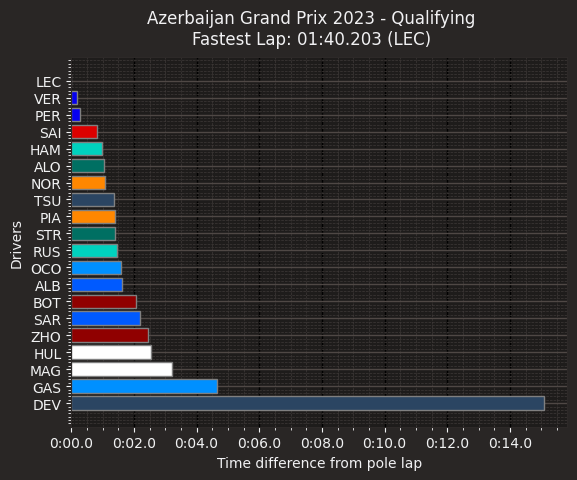

In [3]:


drivers = pd.unique(fp.laps['Driver'])
best_laps = list()
for driver in drivers:
        best_laps.append(fp.laps.pick_driver(driver).pick_fastest())
fastest_laps = Laps(best_laps).sort_values(by='LapTime').reset_index(drop=True)

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']

team_colors = list()
for index, lap in fastest_laps.iterlaps():
        color = ff1.plotting.team_color(lap['Team'])
        team_colors.append(color)
        
ff1.plotting.setup_mpl()
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')
plt.xlabel("Time difference from pole lap")
plt.ylabel("Drivers")
plt.suptitle(f"{fp.event['EventName']} {fp.event.year} - {fp.name}\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

# top 10 finishers

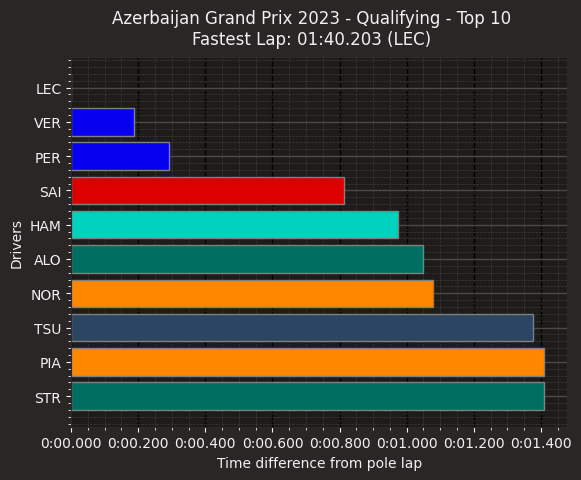

In [9]:
drivers = pd.unique(fp.laps['Driver'])
best_laps = list()
for driver in drivers:
        best_laps.append(fp.laps.pick_driver(driver).pick_fastest())
fastest_laps = Laps(best_laps).sort_values(by='LapTime').reset_index(drop=True)

pole_lap = fastest_laps.pick_fastest()
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime']
fastest_laps.drop(fastest_laps.tail(10).index, inplace=True)
team_colors = list()
for index, lap in fastest_laps.iterlaps():
        color = ff1.plotting.team_color(lap['Team'])
        team_colors.append(color)
        
ff1.plotting.setup_mpl()
fig, ax = plt.subplots()
ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

# show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.set_axisbelow(True)
ax.xaxis.grid(True, which='major', linestyle='--', color='black', zorder=-1000)

lap_time_string = strftimedelta(pole_lap['LapTime'], '%m:%s.%ms')
plt.xlabel("Time difference from pole lap")
plt.ylabel("Drivers")
plt.suptitle(f"{fp.event['EventName']} {fp.event.year} - {fp.name} - Top 10\n"
             f"Fastest Lap: {lap_time_string} ({pole_lap['Driver']})")

plt.show()

# Track dominance

C:\Users\ricca\AppData\Local\Temp\ipykernel_14676\2629313069.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merge = fastest_drv1.append(fastest_drv3)
C:\Users\ricca\AppData\Local\Temp\ipykernel_14676\2629313069.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = merge.append(fastest_drv2)


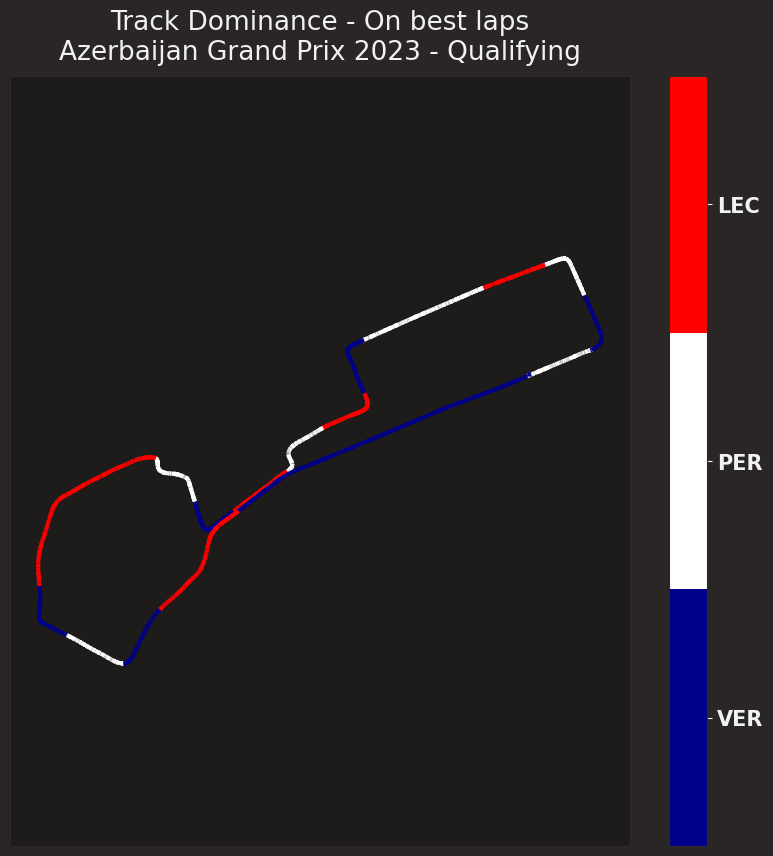

In [10]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
plotting.setup_mpl()

driver1='VER'
driver2='LEC'
driver3='PER'

color_drv1 = "darkblue"
color_drv2 = "red"
color_drv3 = "white"

laps_drv1 = fp_laps.pick_driver(driver1)
laps_drv2 = fp_laps.pick_driver(driver2)
laps_drv3 = fp_laps.pick_driver(driver3)


fastest_drv1 = laps_drv1.pick_fastest().get_telemetry().add_distance()
fastest_drv2 = laps_drv2.pick_fastest().get_telemetry().add_distance()
fastest_drv3 = laps_drv3.pick_fastest().get_telemetry().add_distance()

fastest_drv1['Driver'] = driver1
fastest_drv2['Driver'] = driver2
fastest_drv3['Driver'] = driver3

merge = fastest_drv1.append(fastest_drv3)
telemetry = merge.append(fastest_drv2)

#We want 25 mini-sectors (this can be adjusted up and down)
num_minisectors = 25

# Grab the maximum value of distance that is known in the telemetry
total_distance = total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

# Initiate minisector variable, with 0 (meters) as a starting point.
minisectors = [0]

# Add multiples of minisector_length to the minisectors
for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))


telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

telemetry = telemetry.merge(fastest_driver, on=['Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Convert driver name to integer
telemetry.loc[telemetry['Fastest_driver'] == driver1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver3, 'Fastest_driver_int'] = 2
telemetry.loc[telemetry['Fastest_driver'] == driver2, 'Fastest_driver_int'] = 3


x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

#cmap = cm.get_cmap('cool', 4)
cmap = ListedColormap([color_drv1, color_drv3, color_drv2])
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(3)

plt.rcParams['figure.figsize'] = [10, 10]

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
plt.title(f"Track Dominance - On best laps\n"
          f"{fp.event['EventName']} {fp.event.year} - {fp.name}")
cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,5))
cbar.set_ticks(np.arange(1.5, 4.5))
cbar.set_ticklabels([driver1, driver3, driver2], fontsize=15, fontweight = 'bold')

plt.show()

# Telemetria e gap dal pole man

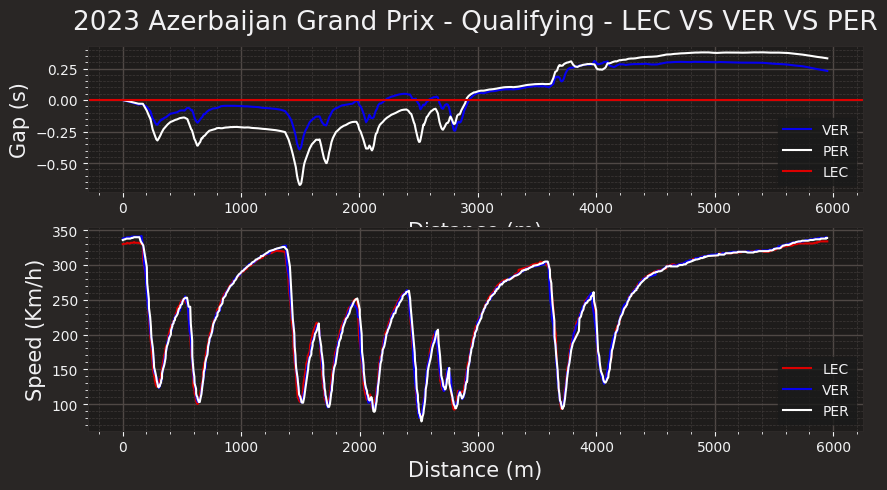

In [6]:
driver_1, driver_2, driver_3 = 'LEC', 'VER', 'PER'
laps_driver_1 = fp.laps.pick_driver(driver_1)
laps_driver_2 = fp.laps.pick_driver(driver_2)
laps_driver_3 = fp.laps.pick_driver(driver_3)

fastest_driver_1 = laps_driver_1.pick_fastest()
fastest_driver_2 = laps_driver_2.pick_fastest()
fastest_driver_3 = laps_driver_3.pick_fastest()

telemetry_driver_1 = fastest_driver_1.get_telemetry().add_distance()
telemetry_driver_2 = fastest_driver_2.get_telemetry().add_distance()
telemetry_driver_3 = fastest_driver_3.get_telemetry().add_distance()

team_driver_1 = fastest_driver_1['Team']
team_driver_2 = fastest_driver_2['Team']
team_driver_3 = fastest_driver_3['Team']

delta_time12, ref_tel12, compare_tel12 = utils.delta_time(fastest_driver_1, fastest_driver_2)
delta_time13, ref_tel13, compare_tel13 = utils.delta_time(fastest_driver_1, fastest_driver_3)

plot_size = [10, 5]
plot_title = f"{fp.event.year} {fp.event.EventName} - {fp.name} - {driver_1} VS {driver_2} VS {driver_3}"
plot_ratios = [0.5, 0.7]
plotting.setup_mpl()
# Make plot a bit bigger
plt.rcParams['figure.figsize'] = plot_size

# Create subplots with different sizes
fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': plot_ratios})

# Set the plot title
ax[0].title.set_text(plot_title)

# Delta line
ax[0].plot(ref_tel12['Distance'], delta_time12, color=ff1.plotting.team_color(team_driver_2), label= driver_2)
ax[0].plot(ref_tel13['Distance'], delta_time13, color='white', label = driver_3)
ax[0].axhline(0, color=ff1.plotting.team_color(team_driver_1), label = driver_1)
ax[0].set_ylabel("Gap (s)", fontsize = 10)
ax[0].set_xlabel("Distance (m)", fontsize=10)
ax[0].yaxis.label.set_size(15)
ax[0].xaxis.label.set_size(15)
ax[0].legend(loc="lower right", prop={'size': 10})


# Speed trace
ax[1].plot(telemetry_driver_1['Distance'], telemetry_driver_1['Speed'], label=driver_1, color=ff1.plotting.team_color(team_driver_1))
ax[1].plot(telemetry_driver_2['Distance'], telemetry_driver_2['Speed'], label=driver_2, color=ff1.plotting.team_color(team_driver_2))
ax[1].plot(telemetry_driver_3['Distance'], telemetry_driver_3['Speed'], label=driver_3, color='white')
ax[1].set_ylabel("Speed (Km/h)", fontsize=10)
ax[1].set_xlabel("Distance (m)", fontsize=10)
ax[1].yaxis.label.set_size(15)
ax[1].xaxis.label.set_size(15)
ax[1].legend(loc="lower right", prop={'size': 10})

# Focus telemetrie

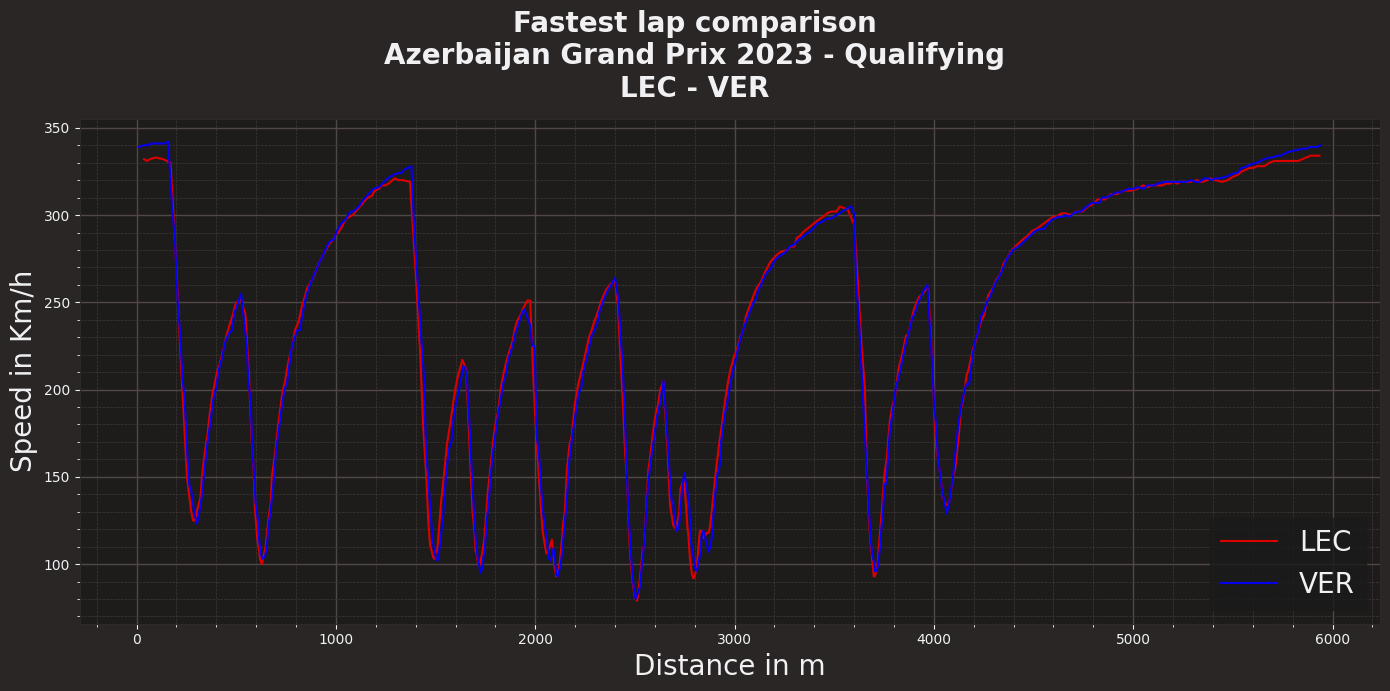

In [21]:
import matplotlib.pyplot as plt
import fastf1.plotting

ff1.plotting.setup_mpl()

lec_lap = fp.laps.pick_driver('LEC').pick_fastest()
ver_lap = fp.laps.pick_driver('VER').pick_fastest()

lec_tel = lec_lap.get_car_data().add_distance()
ver_tel = ver_lap.get_car_data().add_distance()

ferr_color = ff1.plotting.team_color('FER')
rbr_color = ff1.plotting.team_color('RBR')

fig1, ax1 = plt.subplots(1)
fig1.set_figheight(7)
fig1.set_figwidth(14)
ax1.plot(lec_tel['Distance'], lec_tel['Speed'], color = ferr_color, label = 'LEC')
ax1.plot(ver_tel['Distance'], ver_tel['Speed'], color = rbr_color, label = 'VER')

ax1.set_xlabel('Distance in m', size=20)
ax1.set_ylabel('Speed in Km/h', size=20)

ax1.legend(prop={'size': 20})

fig1.suptitle(f"Fastest lap comparison\n"f"{fp.event['EventName']} {fp.event.year} - {fp.name}\n{lec_lap['Driver']} - {ver_lap['Driver']}", size = 20, weight='bold', ha='center')
#plt.subplots_adjust(top=0.85)
fig1.tight_layout()

plt.show()


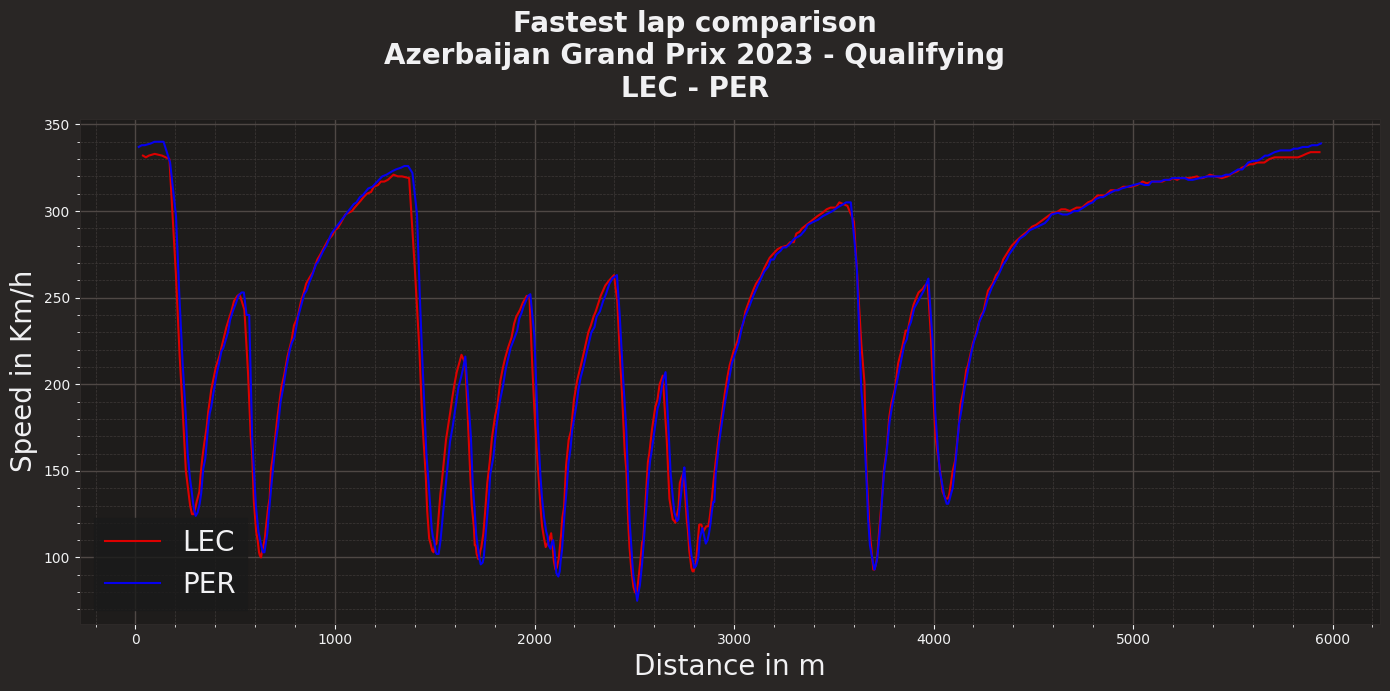

In [24]:
import matplotlib.pyplot as plt
import fastf1.plotting

ff1.plotting.setup_mpl()

lec_lap = fp.laps.pick_driver('LEC').pick_fastest()
per_lap = fp.laps.pick_driver('PER').pick_fastest()

lec_tel = lec_lap.get_car_data().add_distance()
per_tel = per_lap.get_car_data().add_distance()

ferr_color = ff1.plotting.team_color('FER')
rbr_color = ff1.plotting.team_color('RBR')

fig1, ax1 = plt.subplots(1)
fig1.set_figheight(7)
fig1.set_figwidth(14)
ax1.plot(lec_tel['Distance'], lec_tel['Speed'], color = ferr_color, label = 'LEC')
ax1.plot(per_tel['Distance'], per_tel['Speed'], color = rbr_color, label = 'PER')

ax1.set_xlabel('Distance in m', size=20)
ax1.set_ylabel('Speed in Km/h', size=20)

ax1.legend(prop={'size': 20})

fig1.suptitle(f"Fastest lap comparison\n"f"{fp.event['EventName']} {fp.event.year} - {fp.name}\n{lec_lap['Driver']} - {per_lap['Driver']}", size = 20, weight='bold', ha='center')
#plt.subplots_adjust(top=0.85)
fig1.tight_layout()

plt.show()


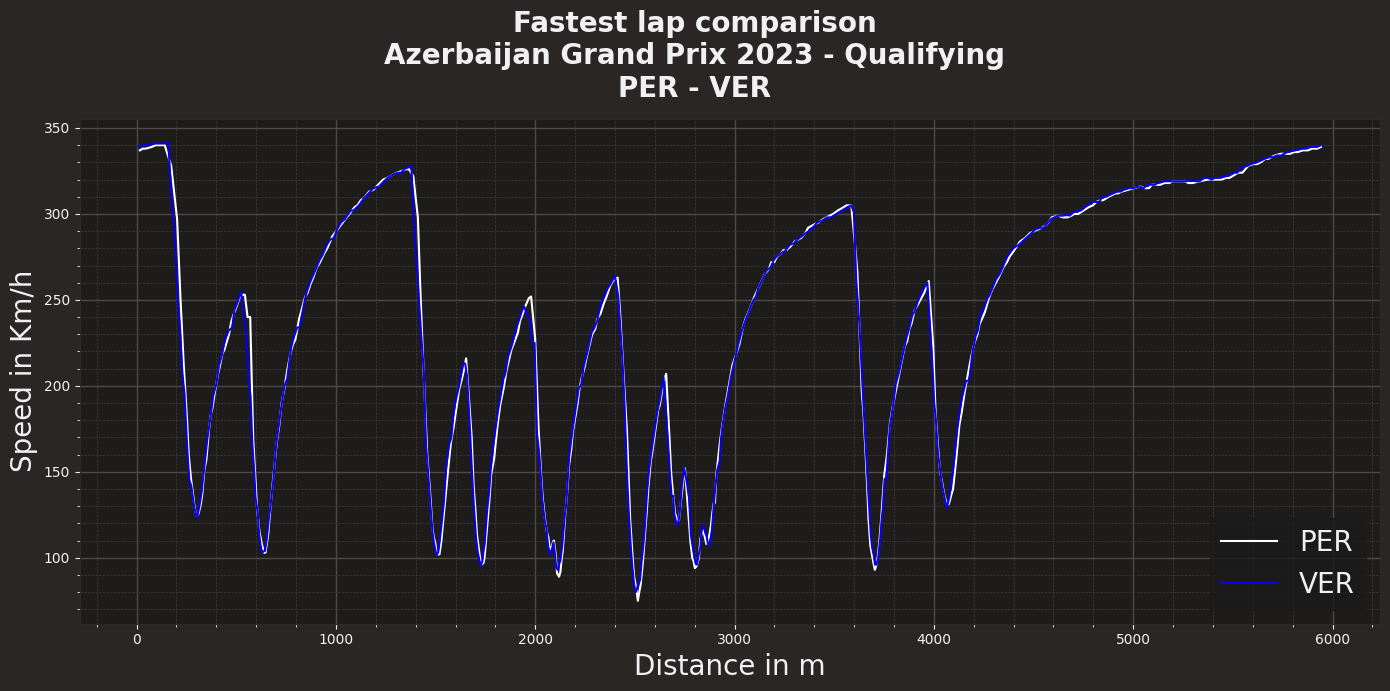

In [25]:
import matplotlib.pyplot as plt
import fastf1.plotting

ff1.plotting.setup_mpl()

per_lap = fp.laps.pick_driver('PER').pick_fastest()
ver_lap = fp.laps.pick_driver('VER').pick_fastest()

per_tel = per_lap.get_car_data().add_distance()
ver_tel = ver_lap.get_car_data().add_distance()

per_color = 'white'
rbr_color = ff1.plotting.team_color('RBR')

fig1, ax1 = plt.subplots(1)
fig1.set_figheight(7)
fig1.set_figwidth(14)
ax1.plot(per_tel['Distance'], per_tel['Speed'], color = per_color, label = 'PER')
ax1.plot(ver_tel['Distance'], ver_tel['Speed'], color = rbr_color, label = 'VER')

ax1.set_xlabel('Distance in m', size=20)
ax1.set_ylabel('Speed in Km/h', size=20)

ax1.legend(prop={'size': 20})

fig1.suptitle(f"Fastest lap comparison\n"f"{fp.event['EventName']} {fp.event.year} - {fp.name}\n{per_lap['Driver']} - {ver_lap['Driver']}", size = 20, weight='bold', ha='center')
#plt.subplots_adjust(top=0.85)
fig1.tight_layout()

plt.show()


# Drag / Downforce

In [7]:
drivers = pd.unique(fp.laps['Driver'])
#elimino i tempi in cui i piloti erano in giro in o out
fp_laps = fp_laps.loc[(fp_laps['PitOutTime'].isnull() & fp_laps['PitInTime'].isnull() & fp_laps['IsAccurate'] == True)]

max_speed_dict = dict.fromkeys(drivers)

for driver in drivers:
    if not driver == "DEV":
        max_speed_dict[driver] = max(fp_laps.pick_driver(driver).pick_fastest().get_car_data()['Speed'])

#creo un dizionario con le velocità medie
mean_speed_dict = dict.fromkeys(drivers)
for driver in drivers:
    if not driver == "DEV":
        mean_speed = np.mean(fp_laps.pick_driver(driver).pick_fastest().get_car_data()["Speed"]) #mean speed
        #mean_speed = sum(fp_laps.pick_driver(driver).pick_fastest().get_car_data()["Speed"]) / len(fp_laps.pick_driver(driver).pick_fastest().get_car_data()["Speed"])
        mean_speed_dict[driver] = (mean_speed)

best_laps = list()
for driver in drivers:
        if not driver == "DEV":
            best_laps.append(fp.laps.pick_driver(driver).pick_fastest())
fastest_laps = Laps(best_laps).sort_values(by='LapTime').reset_index(drop=True)

team_colors = list()
team_color_drvrs = list()
for index, lap in fastest_laps.iterlaps():
        team_color_drvrs.append(lap['Driver'])
        color = ff1.plotting.team_color(lap['Team'])
        team_colors.append(color)

mean_speed_dict_ordered = OrderedDict((k, mean_speed_dict[k]) for k in team_color_drvrs)
max_speed_dict_ordered = OrderedDict((k, max_speed_dict[k]) for k in team_color_drvrs)
mean_speed_dict_ordered = dict(mean_speed_dict_ordered)
max_speed_dict_ordered = dict(max_speed_dict_ordered)
    

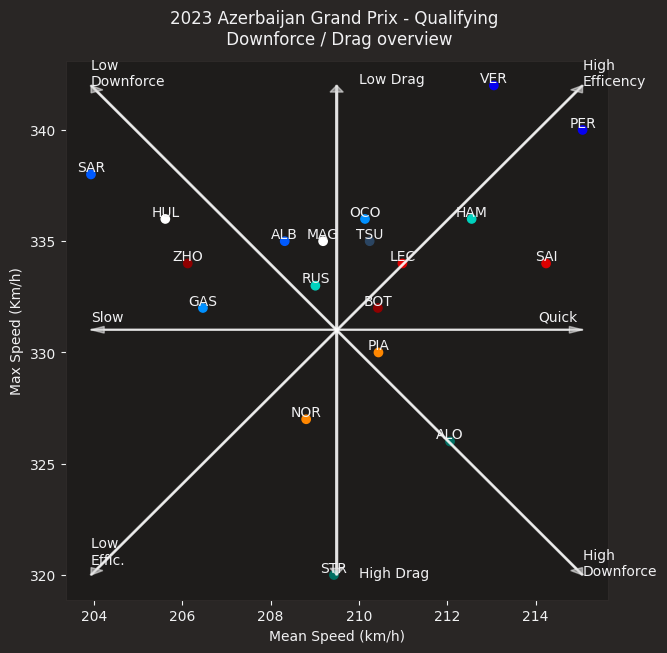

In [37]:
ff1.plotting.setup_mpl()
plt.rcParams["figure.figsize"] = (7,7)
plt.scatter(mean_speed_dict_ordered.values(), max_speed_dict_ordered.values(), color=team_colors)
plt.xlabel("Mean Speed (km/h)")
plt.ylabel("Max Speed (Km/h)")

alpha = 0.5
#freccia verso angolo alto destro
plt.arrow(x = min(mean_speed_dict_ordered.values()) , y = min(max_speed_dict_ordered.values()), 
          dx = ((max(mean_speed_dict_ordered.values()))-min(mean_speed_dict_ordered.values())), 
          dy=(max(max_speed_dict_ordered.values())-min(max_speed_dict_ordered.values())), 
          width=.04, color='white', head_width=.3, head_length=.3, length_includes_head = True, alpha=alpha)
#freccia verso angolo alto sinistro
plt.arrow(x = max(mean_speed_dict_ordered.values()) , y = min(max_speed_dict_ordered.values()), 
          dx = (min(mean_speed_dict_ordered.values()) - (max(mean_speed_dict_ordered.values()))), 
          dy=(max(max_speed_dict_ordered.values())-min(max_speed_dict_ordered.values())), 
          width=.04, color='white', head_width=.3, head_length=.3, length_includes_head = True, alpha=alpha)
#freccia verticale - alto
plt.arrow(x = (sum(mean_speed_dict_ordered.values())/len(mean_speed_dict_ordered))-0.3, y = min(max_speed_dict_ordered.values()), 
          dx = 0, 
          dy=(max(max_speed_dict_ordered.values())-min(max_speed_dict_ordered.values())), 
          width=.04, color='white', head_width=.3, head_length=.3, length_includes_head = True, alpha=alpha)
#freccia orizzontale - destra
plt.arrow(x = max(mean_speed_dict_ordered.values()) , y = (sum(max_speed_dict_ordered.values())/len(max_speed_dict_ordered))-2.4, 
          dx = (min(mean_speed_dict_ordered.values()) - (max(mean_speed_dict_ordered.values()))),
          dy=0, 
          width=.04, color='white', head_width=.3, head_length=.3, length_includes_head = True, alpha=alpha)
#freccia verso angolo in basso a sinistra
plt.arrow(x = max(mean_speed_dict_ordered.values()) , y = max(max_speed_dict_ordered.values()), 
          dx = min(mean_speed_dict_ordered.values()) - ((max(mean_speed_dict_ordered.values()))), 
          dy=(min(max_speed_dict_ordered.values())-max(max_speed_dict_ordered.values())), 
          width=.04, color='white', head_width=.3, head_length=.3, length_includes_head = True, alpha=alpha)
#freccia verso angolo in basso a destra
plt.arrow(x = min(mean_speed_dict_ordered.values()) , y = max(max_speed_dict_ordered.values()), 
          dx =  (max(mean_speed_dict_ordered.values())) - min(mean_speed_dict_ordered.values()), 
          dy=min(max_speed_dict_ordered.values()) - max(max_speed_dict_ordered.values()), 
          width=.04, color='white', head_width=.3, head_length=.3, length_includes_head = True, alpha=alpha)
#freccia verticale - basso
plt.arrow(x = (sum(mean_speed_dict_ordered.values())/len(mean_speed_dict_ordered))-0.3 , y = max(max_speed_dict_ordered.values()), 
          dx = 0, 
          dy=min(max_speed_dict_ordered.values()) - max(max_speed_dict_ordered.values()), 
          width=.04, color='white', head_width=.3, head_length=.3, length_includes_head = True, alpha=alpha)
#freccia orizzontale - sinistra
plt.arrow(x = min(mean_speed_dict_ordered.values()) , y = (sum(max_speed_dict_ordered.values())/len(max_speed_dict_ordered))-2.4, 
          dx =  (max(mean_speed_dict_ordered.values()) - min(mean_speed_dict_ordered.values())),
          dy=0, 
          width=.04, color='white', head_width=.3, head_length=.3, length_includes_head = True, alpha=alpha)

plt.annotate('High \nEfficency', xy = (max(mean_speed_dict_ordered.values()), max(max_speed_dict_ordered.values())))
plt.annotate('Low \nDownforce', xy = (min(mean_speed_dict_ordered.values()), max(max_speed_dict_ordered.values())))
plt.annotate('High \nDownforce', xy = (max(mean_speed_dict_ordered.values()), min(max_speed_dict_ordered.values())))
plt.annotate('Low \nEffic.', xy = (min(mean_speed_dict_ordered.values()), min(max_speed_dict_ordered.values())+0.5))

plt.annotate('Quick', xy = (max(mean_speed_dict_ordered.values())-1, (sum(max_speed_dict_ordered.values())/len(max_speed_dict_ordered))-2))
plt.annotate('Slow', xy = (min(mean_speed_dict_ordered.values()), (sum(max_speed_dict_ordered.values())/len(max_speed_dict_ordered))-2))
plt.annotate('Low Drag', xy = ((sum(mean_speed_dict_ordered.values())/len(mean_speed_dict_ordered))+0.2, max(max_speed_dict_ordered.values())+0.1))
plt.annotate('High Drag', xy =((sum(mean_speed_dict_ordered.values())/len(mean_speed_dict_ordered))+0.2, min(max_speed_dict_ordered.values())-0.1))

for (xi, yi, zi) in zip(mean_speed_dict_ordered.values(), max_speed_dict_ordered.values(), mean_speed_dict_ordered):
    plt.text(xi, yi, zi, va='bottom', ha='center')



plt.title(f"{fp.event.year} {fp.event.EventName} - {fp.name} \n Downforce / Drag overview", fontsize = 12)

plt.show()